In [2]:
import os, json
import numpy as np
from gensim.models import KeyedVectors

# ==== 1) 选择 SPPMI 的超参并加载 ====
win, dim = [4, 6, 8], [100, 200]  # 举例：你也可以换成 4/6, 100/200

def get_model(window, dimension):
    save_dir = "./models_sppmi"
    emb_path = os.path.join(save_dir, f"emb_win{window}_dim{dimension}.npy")
    id2word_path = "id2word.json"          # 你的词表文件（前面已保存过）

    emb = np.load(emb_path)                # shape: (V, dim)
    with open(id2word_path, "r", encoding="utf-8") as f:
        id2word = json.load(f)

    # 把 id2word 统一成 list 形式
    try:
        vocab_words = [id2word[str(i)] for i in range(len(id2word))]
    except KeyError:
        vocab_words = [id2word[i] for i in range(len(id2word))]

    # ==== 2) 封装成 KeyedVectors ====
    kv = KeyedVectors(vector_size=emb.shape[1])
    kv.add_vectors(vocab_words, emb)
    kv.fill_norms()  # 计算范数，most_similar更快

    # ==== 3) 做一个带 .wv 的轻量包装（与 Word2Vec 接口一致）====
    class SPPMIModel:
        def __init__(self, kv):
            self.wv = kv

    model = SPPMIModel(kv)
    return model

model = get_model(win[0], dim[1])


In [3]:
import itertools


# ---------- Step 3: Analogy (king - man + woman ≈ ?) ----------
def safe_analogy(positive, negative, topn=10, label="analogy", model=None):
    if any(w not in model.wv for w in positive + negative):
        missing = [w for w in positive + negative if w not in model.wv]
        print(f"\n[WARN] Cannot compute {label}; OOV words: {missing}")
        return
    print(f"\n[INFO] {label}: positive={positive}, negative={negative}")
    for term, score in model.wv.most_similar(positive=positive, negative=negative, topn=topn):
        print(f"  {term:>15s}  {score:.4f}")


# ==== 4) 直接调用你原来的 safe_analogy ====
# 假设 safe_analogy 已经在作用域中

for win, dim in itertools.product([4,6,8], [100,200]):
    model = get_model(win, dim)
    print("win", win, "dim", dim)
    # safe_analogy(["king", "woman"], ["man"], label="king - man + woman = ?", model=model)
    safe_analogy(["good","smaller"], ["small"], label="big - small + smaller", model=model, topn=5)




win 4 dim 100

[INFO] big - small + smaller: positive=['good', 'smaller'], negative=['small']
           giving  0.9017
        something  0.9008
            meant  0.9004
            makes  0.8991
             give  0.8975
win 4 dim 200

[INFO] big - small + smaller: positive=['good', 'smaller'], negative=['small']
           better  0.8472
            thing  0.8397
             give  0.8376
             ones  0.8357
       everything  0.8342
win 6 dim 100

[INFO] big - small + smaller: positive=['good', 'smaller'], negative=['small']
            meant  0.9153
           giving  0.9073
        something  0.9061
            doing  0.9031
             ones  0.9028


/opt/anaconda3/envs/nlp_dl/lib/python3.9/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


win 6 dim 200

[INFO] big - small + smaller: positive=['good', 'smaller'], negative=['small']
           better  0.8537
        something  0.8483
             come  0.8477
             ones  0.8475
             give  0.8474
win 8 dim 100

[INFO] big - small + smaller: positive=['good', 'smaller'], negative=['small']
            meant  0.9168
        something  0.9069
             give  0.9067
             call  0.9031
           giving  0.9031
win 8 dim 200

[INFO] big - small + smaller: positive=['good', 'smaller'], negative=['small']
           better  0.8636
            meant  0.8619
              how  0.8617
        something  0.8600
              say  0.8598


In [4]:
import numpy as np
import itertools

# ========== 你已有的 ==========
# get_model(win, dim)  -> 返回 Word2Vec 或封装了 .wv 的 SPPMI/GloVe 模型
# safe_analogy(...)    -> 你现有的打印函数（可保留）

# ========== 评测工具 ==========
def _cos_all(kv, q):
    """对 kv 中所有词计算与 q 的余弦，返回 numpy 向量（不含范数填充时可用 kv.fill_norms() 提速）"""
    return kv.cosine_similarities(q, kv.vectors)

def _rank_of_word(kv, target, scores, banned):
    """返回 target 在降序中的名次(从1开始)与其score；若不在词表返回 (None, None)"""
    if target not in kv:
        return None, None
    scores = scores.copy()
    for w in banned:
        if w in kv: scores[kv.key_to_index[w]] = -1e9
    order = np.argsort(-scores)
    rank = int(np.where(order == kv.key_to_index[target])[0][0]) + 1
    return rank, float(scores[kv.key_to_index[target]])

def evaluate_analogies(model, pairs, topn=10, ks=(1,5,10)):
    """
    pairs: list of tuples (a,b,c,d) 表示 a:b :: c:d（d为GT）
    返回:
      metrics: dict { 'acc@1':..., 'acc@5':..., 'acc@10':..., 'mrr':..., 'counted':N }
      rows:    list of dict for each pair { 'pair':(a,b,c,d), 'rank':r, 'score':s, 'topk':[(w,score),...] }
    """
    kv = model.wv if hasattr(model, "wv") else model
    if hasattr(kv, "fill_norms"): kv.fill_norms()

    counted = 0
    hits = {k:0 for k in ks}
    rr_sum = 0.0
    rows = []

    for (a,b,c,d) in pairs:
        # 跳过有 OOV 的
        if any(w not in kv for w in [a,b,c,d]):
            rows.append({'pair':(a,b,c,d), 'rank':None, 'score':None, 'topk':[]})
            continue

        q = kv[b] - kv[a] + kv[c]     # 3CosAdd
        scores = _cos_all(kv, q)
        banned = {a,b,c}              # 排除已知词
        # 计算GT排名与分数
        rank, score = _rank_of_word(kv, d, scores, banned)
        if rank is None:
            rows.append({'pair':(a,b,c,d), 'rank':None, 'score':None, 'topk':[]})
            continue

        # 取TopN列表（用于表格展示）
        sc2 = scores.copy()
        for w in banned:
            if w in kv: sc2[kv.key_to_index[w]] = -1e9
        order = np.argsort(-sc2)[:topn]
        topk = [(kv.index_to_key[i], float(sc2[i])) for i in order]

        counted += 1
        rr_sum += 1.0/rank
        for k in ks:
            if rank <= k: hits[k] += 1

        rows.append({'pair':(a,b,c,d), 'rank':rank, 'score':score, 'topk':topk})

    metrics = {'counted': counted, 'mrr': (rr_sum/counted if counted else 0.0)}
    for k in ks:
        metrics[f'acc@{k}'] = (hits[k]/counted if counted else 0.0)
    return metrics, rows

# ========== 你的20组类比（示例占位，替换成你的真实清单） ==========
# 语义/句法各类混合更稳健；你可直接替换/扩充到20对
pairs20 = [
    ("king","queen","man","woman"),
    ("paris","france","rome","italy"),
    ("berlin","germany","tokyo","japan"),
    ("big","bigger","small","smaller"),
    ("good","better","bad","worse"),
    ("run","ran","write","wrote"),
    ("walk","walked","go","went"),
    ("car","cars","dog","dogs"),
    ("fast","faster","slow","slower"),
    ("long","longer","short","shorter"),
    ("india","rupee","usa","dollar"),
    ("france","euro","japan","yen"),
    ("london","uk","madrid","spain"),
    ("he","his","she","her"),
    ("boy","boys","girl","girls"),
    ("code","coding","swim","swimming"),
    ("sing","sang","go","went"),
    ("smart","smarter","cold","colder"),
    ("warm","warmer","cool","cooler"),
    ("china","beijing","japan","tokyo"),
]

# ========== 跑所有 (win, dim)，打印指标 + 生成LaTeX行 ==========
def latex_line_from_row(row, show_top=5):
    """把单条样本转为 LaTeX 表格的一行（Top-5里用绿色高亮 GT）"""
    (a,b,c,d) = row['pair']
    cells = []
    for i,(w,sc) in enumerate(row['topk'][:show_top], start=1):
        if w == d:
            cells.append(f"\\cellcolor{{green!20}}{w} ({sc:.2f})")
        else:
            cells.append(f"{w} ({sc:.2f})")
    # 不足5个用空白填充，保持列数整齐
    while len(cells) < show_top:
        cells.append("--")
    # 末尾附 GT 排名与分数
    r = "--" if row['rank'] is None else str(row['rank'])
    s = "--" if row['score'] is None else f"{row['score']:.2f}"
    return f"{a}:{b} :: {c}:{d} & " + " & ".join(cells) + f" & {r} & {s} \\\\"

window_sizes = [4,6,8]
embed_dims   = [100,200]

all_metrics = {}  # {(win,dim): metrics}
all_tables  = {}  # {(win,dim): list_of_lines}

for win, dim in itertools.product(window_sizes, embed_dims):
    model = get_model(win, dim)  # 你的加载函数
    metrics, rows = evaluate_analogies(model, pairs20, topn=10, ks=(1,5,10))
    all_metrics[(win,dim)] = metrics

    # 生成 LaTeX 的多行（每个 analogy 一行）
    lines = [latex_line_from_row(r, show_top=5) for r in rows]
    all_tables[(win,dim)] = lines

    print(f"[win={win}, dim={dim}] counted={metrics['counted']}, "
          f"acc@1={metrics['acc@1']:.3f}, acc@5={metrics['acc@5']:.3f}, "
          f"acc@10={metrics['acc@10']:.3f}, MRR={metrics['mrr']:.3f}")


/opt/anaconda3/envs/nlp_dl/lib/python3.9/site-packages/gensim/models/keyedvectors.py:1162: RuntimeWarning: invalid value encountered in divide
  similarities = dot_products / (norm * all_norms)


[win=4, dim=100] counted=20, acc@1=0.400, acc@5=0.550, acc@10=0.600, MRR=0.461
[win=4, dim=200] counted=20, acc@1=0.450, acc@5=0.550, acc@10=0.600, MRR=0.505
[win=6, dim=100] counted=20, acc@1=0.300, acc@5=0.500, acc@10=0.600, MRR=0.406
[win=6, dim=200] counted=20, acc@1=0.300, acc@5=0.600, acc@10=0.650, MRR=0.434
[win=8, dim=100] counted=20, acc@1=0.350, acc@5=0.550, acc@10=0.600, MRR=0.451
[win=8, dim=200] counted=20, acc@1=0.300, acc@5=0.600, acc@10=0.700, MRR=0.442


In [5]:
import os, itertools
from gensim.test.utils import datapath

save_dir = "./models_word2vec"
ws353_path = datapath('wordsim353.tsv')

for win, dim in itertools.product([4,6,8], [100,200]):

    model = get_model(win, dim)  # 你的加载函数

    pearson, spearman, oov = model.wv.evaluate_word_pairs(ws353_path)
    print(f"[win={win}, dim={dim}]  WS353 spearman={spearman.correlation:.4f}  OOV={oov:.3f}")


[win=4, dim=100]  WS353 spearman=0.5170  OOV=0.850
[win=4, dim=200]  WS353 spearman=0.5332  OOV=0.850
[win=6, dim=100]  WS353 spearman=0.5125  OOV=0.850
[win=6, dim=200]  WS353 spearman=0.5250  OOV=0.850
[win=8, dim=100]  WS353 spearman=0.5077  OOV=0.850
[win=8, dim=200]  WS353 spearman=0.5162  OOV=0.850


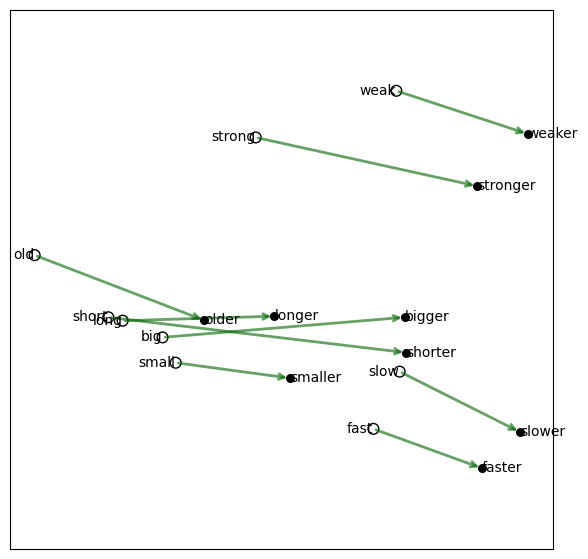

In [6]:
import os
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# 选用 win=4, dim=200 的模型
model = get_model(4, 200)  # 你的加载函数
wv = model.wv
wv.fill_norms(force=True)

# ===== 1) 固定配对（按需增减）=====
fixed_pairs1 = [
    ("drive", "driver"),
    ("swim",  "swimmer"),
    ("teach", "teacher"),
    ("sing",  "singer"),
    ("write", "writer"),
    ("run",   "runner"),
    ("present","presenter"),
    ("act",   "actor"),
]

fixed_pairs2 = [
    ("big","bigger"),
    ("small","smaller"),
    ("fast","faster"),
    ("slow","slower"),
    ("long","longer"),
    ("short","shorter"),
    ("old","older"),
    ("strong","stronger"),
    ("weak","weaker")
]


# 过滤 OOV，仅保留模型词表里都有的配对
pairs = [(s,t) for (s,t) in fixed_pairs2 if (s in wv and t in wv)]
if not pairs:
    raise ValueError("所有配对都不在词表里，请换一批更常见的词。")

# ===== 2) 收集向量并 PCA 到 2D =====
points, labels, roles = [], [], []  # roles: 'src' or 'tgt'
for s,t in pairs:
    points.append(wv[s]); labels.append(s); roles.append('src')
    points.append(wv[t]); labels.append(t); roles.append('tgt')

points = np.vstack(points)
pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(points)

# ===== 3) 画图：一对一箭头，不做最近邻 =====
plt.figure(figsize=(7,7))
ax = plt.gca()

for k,(s,t) in enumerate(pairs):
    i_src = 2*k
    i_tgt = 2*k + 1
    x1,y1 = xy[i_src]; x2,y2 = xy[i_tgt]

    # 起点（空心）
    plt.scatter(x1, y1, facecolors='none', edgecolors='k', s=60, zorder=3)
    plt.text(x1, y1, labels[i_src], fontsize=10, va='center', ha='right', zorder=4)

    # 终点（实心）
    plt.scatter(x2, y2, c='k', s=30, zorder=3)
    plt.text(x2, y2, labels[i_tgt], fontsize=10, va='center', ha='left', zorder=4)

    # 箭头（只连固定目标）
    ax.annotate("",
        xy=(x2,y2), xytext=(x1,y1),
        arrowprops=dict(arrowstyle="->", lw=2, color='darkgreen', alpha=0.6))

# plt.title("Fixed pairs visualization (verb → agent noun)")
plt.axis('equal'); plt.xticks([]); plt.yticks([]); plt.box(True)
plt.show()


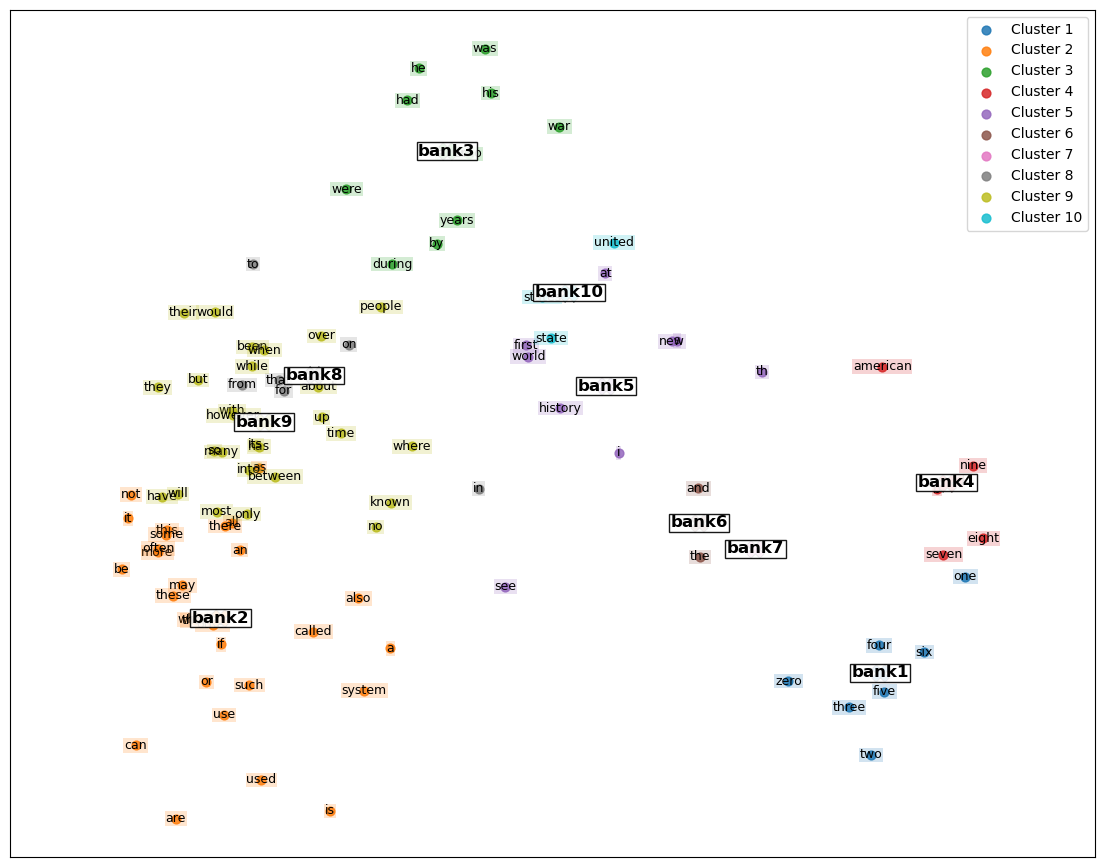

In [7]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1) 取前100个高频词
topN = 100
words = model.wv.index_to_key[:topN]
X = model.wv[words]

# 2) KMeans 聚成 10 类
k = 10
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# 3) PCA 到 2D（对所有点和聚类中心一起降维，避免失真）
pca = PCA(n_components=2, random_state=42)
X_all = np.vstack([X, centers])
XY_all = pca.fit_transform(X_all)
XY = XY_all[:len(X)]                  # 词的坐标
centers_2d = XY_all[len(X):]          # 质心的坐标

# 4) 画图
plt.figure(figsize=(14, 11))
ax = plt.gca()
cmap = plt.get_cmap("tab10")

# 4.1 每个簇分开画，颜色明显
for i in range(k):
    idx = np.where(labels == i)[0]
    plt.scatter(XY[idx,0], XY[idx,1],
                s=40, alpha=0.85,
                color=cmap(i),
                label=f"Cluster {i+1}")
    # 每个词打标签，背景染成簇颜色（半透明）
    for j in idx:
        plt.text(XY[j,0], XY[j,1], words[j],
                 fontsize=9, ha='center', va='center',
                 bbox=dict(facecolor=cmap(i), alpha=0.2,
                           edgecolor='none', pad=0.5))

# 4.2 在每个簇质心标簇名（bank1...bank10）
prefix = "bank"
for i, (cx, cy) in enumerate(centers_2d, start=1):
    plt.scatter(cx, cy, s=160, c=[cmap((i-1) % 10)],
                marker='X', edgecolors='k',
                linewidths=0.5, zorder=3)
    plt.text(cx, cy, f"{prefix}{i}",
             fontsize=12, weight='bold', color='black',
             ha='center', va='center',
             bbox=dict(facecolor='white', edgecolor='black',
                       alpha=0.9, pad=1.0))

plt.axis('equal')
plt.xticks([]); plt.yticks([])
plt.legend()
plt.box(True)
plt.show()


